In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

orders = pd.read_csv('data/olist_orders_dataset.csv')
items = pd.read_csv('data/olist_order_items_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')

print("Dane wczytane pomyślnie.")

Dane wczytane pomyślnie.


In [2]:
df = pd.merge(orders, items, on='order_id', how='inner')
df = pd.merge(df, products, on='product_id', how='inner')

df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

df = df[df['order_status'] == 'delivered']

cols_to_keep = [
    'order_id', 'product_id', 'product_category_name',
    'price', 'freight_value', 'order_purchase_timestamp'
]

df = df[[c for c in cols_to_keep if c in df.columns]]

print(f"Rozmiar połączonego datasetu: {df.shape}")
df.head()

Rozmiar połączonego datasetu: (110197, 6)


,order_id,product_id,product_category_name,price,freight_value,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,utilidades_domesticas,29.99,8.72,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,595fac2a385ac33a80bd5114aec74eb8,perfumaria,118.70,22.76,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,aa4383b373c6aca5d8797843e5594415,automotivo,159.90,19.22,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,45.00,27.20,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,65266b2da20d04dbe00c5c2d3bb7859e,papelaria,19.90,8.72,2018-02-13 21:18:39


In [3]:
df.set_index('order_purchase_timestamp', inplace=True)
top_products = df['product_id'].value_counts().head(50).index.tolist()
df_top = df[df['product_id'].isin(top_products)].copy()

print(f"Liczba rekordów dla top 50 produktów: {df_top.shape[0]}")

weekly_data = df_top.groupby('product_id').resample('W').agg({
    'price': 'mean',
    'order_id': 'count'
}).rename(columns={'order_id': 'demand'})

weekly_data = weekly_data.reset_index()

weekly_data['demand'] = weekly_data['demand'].fillna(0)
weekly_data['price'] = weekly_data.groupby('product_id')['price'].ffill()

print("Przykładowe dane po agregacji:")
display(weekly_data.head())

Liczba rekordów dla top 50 produktów: 9757
Przykładowe dane po agregacji:


,product_id,order_purchase_timestamp,price,demand
0,06edb72f1e0c64b14c5b79353f7abea3,2017-05-28,45.95,1
1,06edb72f1e0c64b14c5b79353f7abea3,2017-06-04,45.95,0
2,06edb72f1e0c64b14c5b79353f7abea3,2017-06-11,45.95,2
3,06edb72f1e0c64b14c5b79353f7abea3,2017-06-18,45.95,0
4,06edb72f1e0c64b14c5b79353f7abea3,2017-06-25,45.95,1


In [4]:
# Dołączamy kategorię z powrotem do danych tygodniowych
product_cats = products[['product_id', 'product_category_name']]
weekly_data = pd.merge(weekly_data, product_cats, on='product_id', how='left')

# Obliczamy średnią cenę całej kategorii w danym tygodniu (Market Price)
category_weekly_price = weekly_data.groupby(['product_category_name', 'order_purchase_timestamp'])['price'].mean().reset_index()
category_weekly_price.rename(columns={'price': 'competitor_price'}, inplace=True)

# Łączymy to z naszymi danymi
final_df = pd.merge(weekly_data, category_weekly_price, on=['product_category_name', 'order_purchase_timestamp'], how='left')

# Obliczamy "Price Ratio" - czy jesteśmy drożsi czy tańsi od rynku?
# To jest SUPER cecha dla sieci neuronowej
final_df['price_ratio'] = final_df['price'] / final_df['competitor_price']

print("Gotowy dataset do treningu:")
display(final_df.head())

Gotowy dataset do treningu:


,product_id,order_purchase_timestamp,price,demand,product_category_name,competitor_price,price_ratio
0,06edb72f1e0c64b14c5b79353f7abea3,2017-05-28,45.95,1,cama_mesa_banho,116.95,0.392903
1,06edb72f1e0c64b14c5b79353f7abea3,2017-06-04,45.95,0,cama_mesa_banho,116.95,0.392903
2,06edb72f1e0c64b14c5b79353f7abea3,2017-06-11,45.95,2,cama_mesa_banho,116.95,0.392903
3,06edb72f1e0c64b14c5b79353f7abea3,2017-06-18,45.95,0,cama_mesa_banho,116.95,0.392903
4,06edb72f1e0c64b14c5b79353f7abea3,2017-06-25,45.95,1,cama_mesa_banho,116.95,0.392903


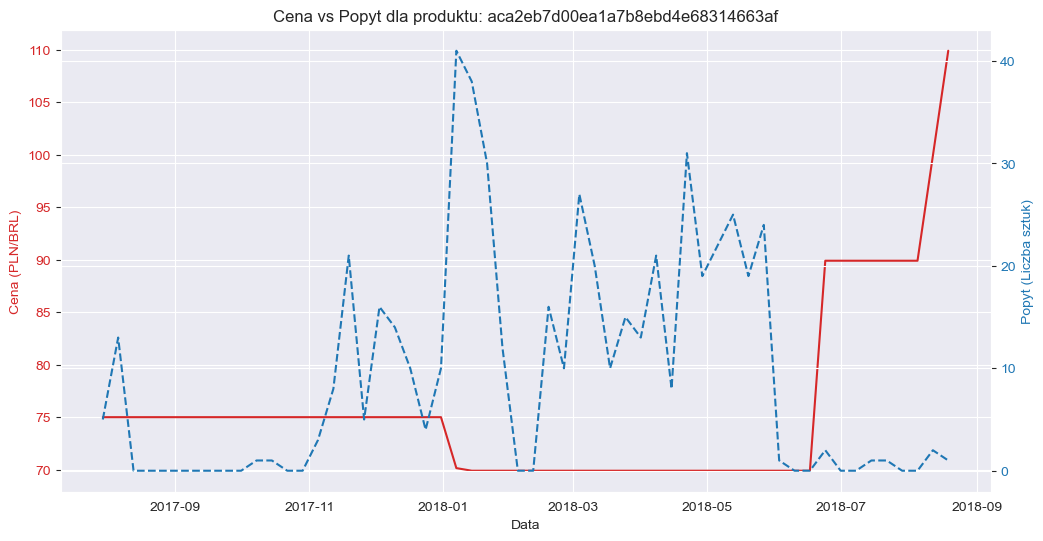

In [5]:
# Wybierzmy jeden produkt do podglądu
sample_product = top_products[0]
data_sample = final_df[final_df['product_id'] == sample_product]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Data')
ax1.set_ylabel('Cena (PLN/BRL)', color='tab:red')
ax1.plot(data_sample['order_purchase_timestamp'], data_sample['price'], color='tab:red', label='Cena')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Popyt (Liczba sztuk)', color='tab:blue')
ax2.plot(data_sample['order_purchase_timestamp'], data_sample['demand'], color='tab:blue', linestyle='--', label='Popyt')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title(f'Cena vs Popyt dla produktu: {sample_product}')
plt.show()

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ['price', 'competitor_price', 'price_ratio']
target = ['demand']

df_clean = final_df.dropna(subset=features + target)

X = df_clean[features].values
Y = df_clean[target].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
Y_train_scaled = scaler_y.fit_transform(Y_train)
Y_test_scaled = scaler_y.transform(Y_test)

print("Input dimensions:", X_train_scaled.shape[1])

ModuleNotFoundError: No module named 'sklearn'

In [36]:
def build_model(input_dim):
    model = keras.Sequential()

    model.add(layers.Dense(
        96,
        activation='relu',
        input_shape=(input_dim,),
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='linear'))

    # Kompilacja
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

input_dim = X_train_scaled.shape[1]
model = build_model(input_dim)

es = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

print("Rozpoczynam trening...")
history = model.fit(
    X_train_scaled, Y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Rozpoczynam trening...
Epoch 1/200


C:\Users\mateuszlamla\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7384 - mae: 1.1888 - val_loss: 1.1767 - val_mae: 0.6481
Epoch 2/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9987 - mae: 0.9979 - val_loss: 1.1780 - val_mae: 0.6509
Epoch 3/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8496 - mae: 0.9494 - val_loss: 1.1504 - val_mae: 0.6596
Epoch 4/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6963 - mae: 0.8952 - val_loss: 1.1556 - val_mae: 0.6413
Epoch 5/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5282 - mae: 0.8443 - val_loss: 1.1588 - val_mae: 0.6410
Epoch 6/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4218 - mae: 0.7912 - val_loss: 1.1464 - val_mae: 0.6408
Epoch 7/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3631 - mae: 0.7786 - val_loss: 1.1393 - val_mae: 0.6408
Epoch 8/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3376 - mae: 0.7563 - val_loss: 1.1204 - val_mae: 0.6281
Epoch 9/200
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2911 - mae: 0.7

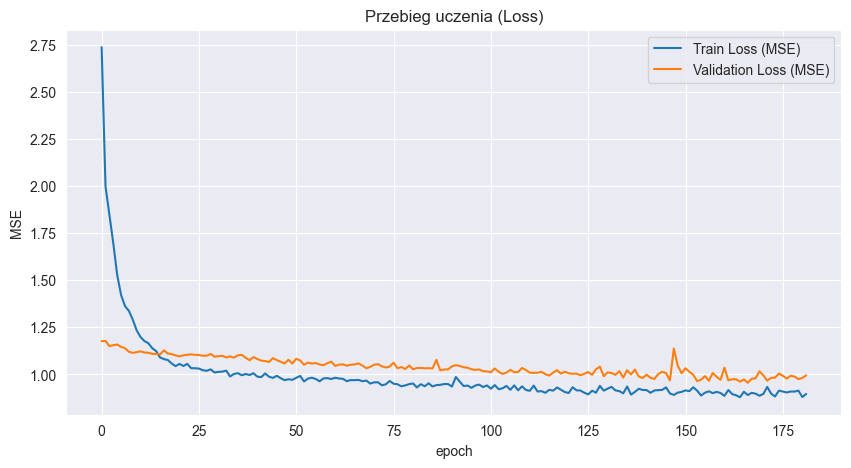

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
   Prawdziwy Popyt  Przewidywany Popyt
0              0.0            1.730996
1              3.0            3.233471
2              0.0            2.832457
3              2.0            3.103785
4              3.0            2.583693
5              0.0            1.993308
6              0.0            2.985538
7              0.0            1.542477
8              2.0            1.972377
9              2.0            4.453569


In [37]:
import matplotlib.pyplot as plt

# Wykres straty (Loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Przebieg uczenia (Loss)')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Sprawdzenie na zbiorze testowym
# Predykcja (zwraca wartości przeskalowane)
preds_scaled = model.predict(X_test_scaled)

# Odwrócenie skalowania (żeby zobaczyć prawdziwe liczby sprzedanych sztuk)
preds_real = scaler_y.inverse_transform(preds_scaled)
y_test_real = scaler_y.inverse_transform(Y_test_scaled)

# Porównanie dla pierwszych 10 próbek
results = pd.DataFrame({
    'Prawdziwy Popyt': y_test_real.flatten(),
    'Przewidywany Popyt': preds_real.flatten()
})
print(results.head(10))

In [39]:
from langchain.tools import tool

# Zakładam, że masz zmienne: model, scaler_x, scaler_y
# oraz średnią cenę konkurencji (np. wyciągniętą z datasetu jako stałą dla uproszczenia demo)
AVG_COMPETITOR_PRICE = final_df['competitor_price'].mean()

@tool
def predict_demand_tool(price: float, competitor_price: float = AVG_COMPETITOR_PRICE) -> str:
    """
    Używa sieci neuronowej do przewidzenia popytu (liczby sprzedaży) dla danej ceny produktu.
    Można opcjonalnie podać cenę konkurencji (domyślnie bierze średnią rynkową).
    Zwraca tekst z przewidywaną liczbą sztuk i przychodem.
    """

    # 1. Obliczamy cechy pochodne (tak jak w treningu!)
    # Pamiętasz? Model uczył się na [price, competitor_price, price_ratio]
    price_ratio = price / competitor_price

    # 2. Tworzymy wektor danych
    input_data = np.array([[price, competitor_price, price_ratio]])

    # 3. Skalowanie (To kluczowe! Bez tego model zgłupieje)
    input_scaled = scaler_x.transform(input_data)

    # 4. Predykcja modelu
    prediction_scaled = model.predict(input_scaled, verbose=0)

    # 5. Odwrócenie skalowania wyniku
    predicted_demand = scaler_y.inverse_transform(prediction_scaled)[0][0]

    # Zabezpieczenie przed ujemnym popytem (sieć może czasem zwrócić -0.1)
    predicted_demand = max(0, round(predicted_demand))

    # Obliczenie przychodu
    revenue = predicted_demand * price

    return (f"Symulacja dla ceny {price} PLN (Konkurencja: {competitor_price:.2f} PLN):\n"
            f"- Przewidywany popyt: {predicted_demand} sztuk\n"
            f"- Przewidywany przychód: {revenue:.2f} PLN")

# Testujemy czy wrapper działa bez LLM
print(predict_demand_tool.run({"price": 50.0}))
print(predict_demand_tool.run({"price": 120.0}))

Symulacja dla ceny 50.0 PLN (Konkurencja: 104.96 PLN):
- Przewidywany popyt: 3 sztuk
- Przewidywany przychód: 150.00 PLN
Symulacja dla ceny 120.0 PLN (Konkurencja: 104.96 PLN):
- Przewidywany popyt: 5 sztuk
- Przewidywany przychód: 600.00 PLN


In [1]:
import os
import getpass
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import initialize_agent, AgentType
from langchain_core.prompts import ChatPromptTemplate
from langchain.tools import tool

# --- KONFIGURACJA KLUCZA ---
# Jeśli nie masz klucza, wejdź na: https://aistudio.google.com/app/apikey
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Podaj swój Google API Key: ")

# --- 1. TOOL (To samo co wcześniej - Twój "Kalkulator") ---
# Musimy to zdefiniować jeszcze raz dla porządku
@tool
def predict_demand_tool(price: float, competitor_price: float = 75.0) -> str:
    """
    Używa sieci neuronowej do przewidzenia popytu (liczby sprzedaży) dla danej ceny produktu.
    Można opcjonalnie podać cenę konkurencji (domyślnie 75.0).
    Zwraca tekst z przewidywaną liczbą sztuk i przychodem.
    """
    try:
        # Obliczenia cech
        price_ratio = price / competitor_price
        input_data = np.array([[price, competitor_price, price_ratio]])

        # Skalowanie
        input_scaled = scaler_x.transform(input_data)

        # Predykcja
        prediction_scaled = model.predict(input_scaled, verbose=0)
        predicted_demand = scaler_y.inverse_transform(prediction_scaled)[0][0]

        # Wynik biznesowy
        predicted_demand = max(0, round(predicted_demand)) # Zaokrąglamy do całych sztuk
        revenue = predicted_demand * price

        return (f"ANALIZA MODELU DL:\n"
                f"- Cena: {price} PLN (Konkurencja: {competitor_price} PLN)\n"
                f"- Prognozowana sprzedaż: {predicted_demand} sztuk\n"
                f"- Prognozowany przychód: {revenue:.2f} PLN")
    except Exception as e:
        return f"Błąd modelu: {str(e)}"

# --- 2. MÓZG AGENTA (TUTAJ ZMIANA NA GOOGLE) ---
# Używamy modelu gemini-1.5-flash, bo jest szybki i tani/darmowy
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    convert_system_message_to_human=True # Ważne dla niektórych wersji LangChaina
)

# --- 3. PROMPT I ZŁOŻENIE AGENTA ---
tools = [predict_demand_tool]

prompt = ChatPromptTemplate.from_messages([
    ("system", "Jesteś analitykiem cenowym (Pricing Specialist). "
               "Twoim zadaniem jest optymalizacja przychodu używając dostępnych narzędzi AI. "
               "Nie zgaduj liczb - ZAWSZE używaj narzędzia 'predict_demand_tool' do sprawdzenia scenariuszy. "
               "Po analizie, przedstaw rekomendację w punktach."),
    ("human", "{input}"),
    ("placeholder", "{agent_scratchpad}"),
])

agent_executor = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION, # Typ agenta dla starszych wersji
    verbose=True,
    handle_parsing_errors=True # Ważne, żeby agent się nie wywalał jak źle sformatuje odpowiedź
)

# --- 4. URUCHOMIENIE ---
query = """
Aktualnie sprzedajemy produkt po 95 PLN.
Zastanawiamy się nad zmianą strategii.
Sprawdź proszę trzy warianty cenowe: 85 PLN, 95 PLN i 105 PLN.
Zakładamy, że konkurencja trzyma cenę 90 PLN.
Która z tych opcji da nam największy przychód?
"""

print("Agent myśli)...")
response = agent_executor.invoke({"input": query})

print("\n--- REKOMENDACJA ---")
print(response['output'])

ImportError: cannot import name 'initialize_agent' from 'langchain.agents' (C:\Users\mateuszlamla\PyCharmMiscProject\.venv\Lib\site-packages\langchain\agents\__init__.py)